In [ ]:
!pip install kaggle

from google.colab import files
files.upload()   # Upload kaggle.json here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"estifanosgebremedhin","key":"c89f0e0bce9298e41cf25b169e0f22bb"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d vivek468/beginner-chest-xray-image-classification


Dataset URL: https://www.kaggle.com/datasets/vivek468/beginner-chest-xray-image-classification
License(s): other
 99% 2.05G/2.08G [00:27<00:00, 175MB/s]
100% 2.08G/2.08G [00:27<00:00, 79.8MB/s]


In [ ]:
!unzip beginner-chest-xray-image-classification.zip -d data


Streaming output truncated to the last 5000 lines.
  inflating: data/chest_xray/train/NORMAL/NORMAL_3081.jpeg  
  inflating: data/chest_xray/train/NORMAL/NORMAL_3082.jpeg  
  inflating: data/chest_xray/train/NORMAL/NORMAL_3083.jpeg  
  inflating: data/chest_xray/train/NORMAL/NORMAL_3084.jpeg  
  inflating: data/chest_xray/train/NORMAL/NORMAL_3085.jpeg  
  inflating: data/chest_xray/train/NORMAL/NORMAL_3086.jpeg  
  inflating: data/chest_xray/train/NORMAL/NORMAL_3087.jpeg  
  inflating: data/chest_xray/train/NORMAL/NORMAL_3088.jpeg  
  inflating: data/chest_xray/train/NORMAL/NORMAL_3089.jpeg  
  inflating: data/chest_xray/train/NORMAL/NORMAL_309.jpeg  
  inflating: data/chest_xray/train/NORMAL/NORMAL_3090.jpeg  
  inflating: data/chest_xray/train/NORMAL/NORMAL_3091.jpeg  
  inflating: data/chest_xray/train/NORMAL/NORMAL_3092.jpeg  
  inflating: data/chest_xray/train/NORMAL/NORMAL_3093.jpeg  
  inflating: data/chest_xray/train/NORMAL/NORMAL_3094.jpeg  
  inflating: data/chest_xray/train/

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt


In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_dir = "data/chest_xray/train"
val_dir = "data/chest_xray/pred"
test_dir = "data/chest_xray/test"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_gen = test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 7315 images belonging to 2 classes.
Found 9 images belonging to 2 classes.
Found 620 images belonging to 2 classes.


# ResNet50

In [ ]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze convolution layers
for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(base_model.input, output)

model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 190s 759ms/step - accuracy: 0.4985 - loss: 0.7977 - val_accuracy: 0.8889 - val_loss: 0.6373
Epoch 2/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 165s 718ms/step - accuracy: 0.5808 - loss: 0.6767 - val_accuracy: 0.7778 - val_loss: 0.5808
Epoch 3/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 159s 695ms/step - accuracy: 0.6776 - loss: 0.6290 - val_accuracy: 0.7778 - val_loss: 0.5361
Epoch 4/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 159s 693ms/step - accuracy: 0.7161 - loss: 0.6002 - val_accuracy: 0.8889 - val_loss: 0.4933
Epoch 5/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 156s 681ms/step - accuracy: 0.7486 - loss: 0.5666 - val_accuracy: 0.8889 - val_loss: 0.4539
Epoch 6/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 159s 693ms/step - accuracy: 0.7607 - loss: 0.5479 - val_accuracy: 0.8889 - val_loss: 0.4186
Epoch 7/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 159s 695ms/step - accuracy: 0.7667 - loss: 0.5320 - val_accuracy: 0.7778 - val_loss: 0.4072
Epoch 8/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 157s 687ms/step - accuracy: 0.7637 -

In [ ]:
test_loss, test_acc = model.evaluate(test_gen)
print("Test Accuracy:", test_acc)


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 465ms/step - accuracy: 0.8190 - loss: 0.4637
Test Accuracy: 0.8032258152961731


20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 446ms/step


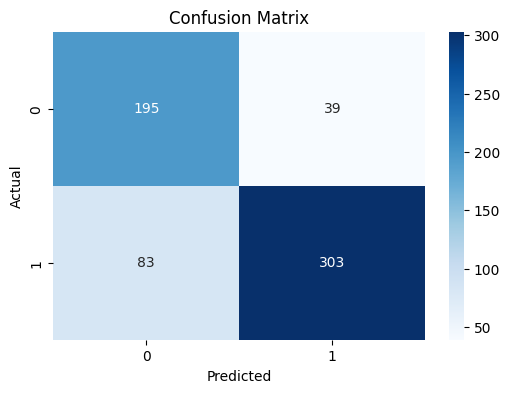

              precision    recall  f1-score   support

      NORMAL       0.70      0.83      0.76       234
   PNEUMONIA       0.89      0.78      0.83       386

    accuracy                           0.80       620
   macro avg       0.79      0.81      0.80       620
weighted avg       0.82      0.80      0.81       620



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# True labels
true_labels = test_gen.classes

# Predictions
pred_probs = model.predict(test_gen)
pred_labels = (pred_probs > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print(classification_report(true_labels, pred_labels, target_names=['NORMAL', 'PNEUMONIA']))


In [ ]:
model.save("pneumonia_resnet50.keras")


In [ ]:
from google.colab import files
files.download("pneumonia_resnet50.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image

uploaded = files.upload()
img_path = list(uploaded.keys())[0]

img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, 0)

pred = model.predict(img_array)[0][0]

if pred > 0.5:
    print("Prediction: PNEUMONIA")
else:
    print("Prediction: NORMAL")


Saving person3_virus_16.jpeg to person3_virus_16.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Prediction: PNEUMONIA


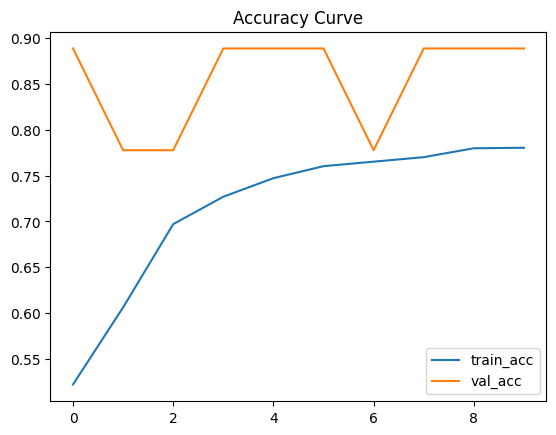

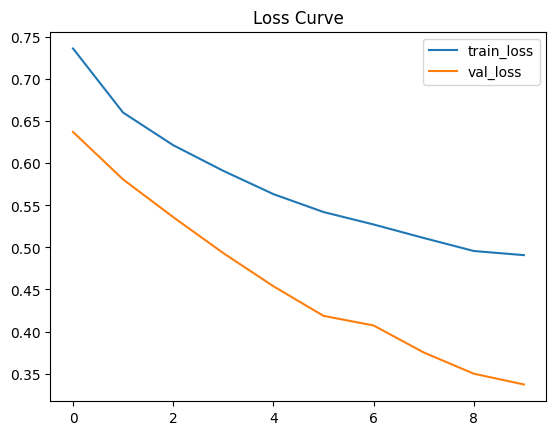

In [ ]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title("Accuracy Curve")
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title("Loss Curve")
plt.show()


In [ ]:
#DenseNet
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load DenseNet121 (without top classifier)
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze convolution base
for layer in base_model.layers:
    layer.trainable = False

# Add custom classifier
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)

densenet_model = Model(inputs=base_model.input, outputs=output)

densenet_model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

densenet_model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,300,161 (27.85 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
densenet_history = densenet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


Epoch 1/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 222s 831ms/step - accuracy: 0.7451 - loss: 0.5038 - val_accuracy: 1.0000 - val_loss: 0.1529
Epoch 2/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 158s 689ms/step - accuracy: 0.8842 - loss: 0.2790 - val_accuracy: 1.0000 - val_loss: 0.0794
Epoch 3/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 158s 688ms/step - accuracy: 0.9077 - loss: 0.2361 - val_accuracy: 1.0000 - val_loss: 0.0749
Epoch 4/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 159s 693ms/step - accuracy: 0.9173 - loss: 0.2141 - val_accuracy: 1.0000 - val_loss: 0.0529
Epoch 5/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 161s 701ms/step - accuracy: 0.9198 - loss: 0.2069 - val_accuracy: 1.0000 - val_loss: 0.0456
Epoch 6/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 160s 697ms/step - accuracy: 0.9219 - loss: 0.2029 - val_accuracy: 1.0000 - val_loss: 0.0473
Epoch 7/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 159s 696ms/step - accuracy: 0.9335 - loss: 0.1781 - val_accuracy: 1.0000 - val_loss: 0.0488
Epoch 8/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 159s 696ms/step - accuracy: 0.9270 -

In [ ]:
test_loss, test_acc = densenet_model.evaluate(test_gen)
print("DenseNet Test Accuracy:", test_acc)


20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 861ms/step - accuracy: 0.9107 - loss: 0.1833
DenseNet Test Accuracy: 0.9112903475761414


20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 948ms/step


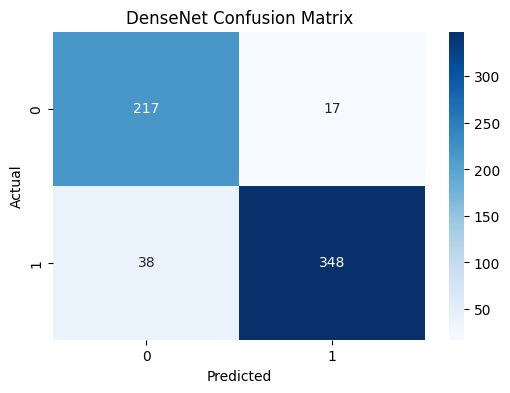

              precision    recall  f1-score   support

      NORMAL       0.85      0.93      0.89       234
   PNEUMONIA       0.95      0.90      0.93       386

    accuracy                           0.91       620
   macro avg       0.90      0.91      0.91       620
weighted avg       0.91      0.91      0.91       620



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# True labels
true_labels = test_gen.classes

# Predictions
pred_probs = densenet_model.predict(test_gen)
pred_labels = (pred_probs > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("DenseNet Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print(classification_report(true_labels, pred_labels, target_names=['NORMAL', 'PNEUMONIA']))


In [ ]:
densenet_model.save("pneumonia_densenet121.keras")


In [ ]:
from google.colab import files
files.download("pneumonia_densenet121.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from tensorflow.keras.preprocessing import image
from google.colab import files
import numpy as np

uploaded = files.upload()
img_path = list(uploaded.keys())[0]

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, 0)

pred = densenet_model.predict(img_array)[0][0]

if pred > 0.5:
    print("DenseNet Prediction: PNEUMONIA")
else:
    print("DenseNet Prediction: NORMAL")


Saving IM-0084-0001.jpeg to IM-0084-0001.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
DenseNet Prediction: NORMAL


In [ ]:
#VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load base model
vgg_base = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze convolution layers
for layer in vgg_base.layers:
    layer.trainable = False

# Classifier
x = Flatten()(vgg_base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)

vgg_model = Model(inputs=vgg_base.input, outputs=output)

vgg_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

vgg_model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
vgg_history = vgg_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


Epoch 1/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 201s 795ms/step - accuracy: 0.8597 - loss: 0.3124 - val_accuracy: 1.0000 - val_loss: 0.0682
Epoch 2/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 167s 720ms/step - accuracy: 0.9367 - loss: 0.1738 - val_accuracy: 0.8889 - val_loss: 0.1640
Epoch 3/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 165s 721ms/step - accuracy: 0.9421 - loss: 0.1578 - val_accuracy: 1.0000 - val_loss: 0.0574
Epoch 4/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 164s 715ms/step - accuracy: 0.9417 - loss: 0.1516 - val_accuracy: 0.8889 - val_loss: 0.1156
Epoch 5/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 163s 712ms/step - accuracy: 0.9462 - loss: 0.1399 - val_accuracy: 1.0000 - val_loss: 0.0204
Epoch 6/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 165s 719ms/step - accuracy: 0.9518 - loss: 0.1404 - val_accuracy: 0.8889 - val_loss: 0.1551
Epoch 7/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 164s 714ms/step - accuracy: 0.9548 - loss: 0.1205 - val_accuracy: 1.0000 - val_loss: 0.0237
Epoch 8/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 163s 712ms/step - accuracy: 0.9516 -

In [ ]:
test_loss, test_acc = vgg_model.evaluate(test_gen)
print("VGG16 Test Accuracy:", test_acc)


20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 786ms/step - accuracy: 0.9560 - loss: 0.1011
VGG16 Test Accuracy: 0.9564515948295593


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 301ms/step


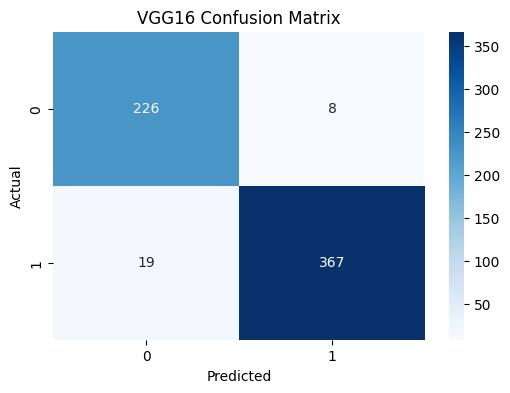

              precision    recall  f1-score   support

      NORMAL       0.92      0.97      0.94       234
   PNEUMONIA       0.98      0.95      0.96       386

    accuracy                           0.96       620
   macro avg       0.95      0.96      0.95       620
weighted avg       0.96      0.96      0.96       620



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# True labels
true_labels = test_gen.classes

# Predictions
vgg_pred_probs = vgg_model.predict(test_gen)
vgg_pred_labels = (vgg_pred_probs > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(true_labels, vgg_pred_labels)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("VGG16 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print(classification_report(true_labels, vgg_pred_labels, target_names=['NORMAL', 'PNEUMONIA']))


In [ ]:
vgg_model.save("pneumonia_vgg16.keras")


In [ ]:
from google.colab import files
files.download("pneumonia_vgg16.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from tensorflow.keras.preprocessing import image
from google.colab import files
import numpy as np

uploaded = files.upload()
img_path = list(uploaded.keys())[0]

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, 0)

vgg_pred = vgg_model.predict(img_array)[0][0]

if vgg_pred > 0.5:
    print("VGG16 Prediction: PNEUMONIA")
else:
    print("VGG16 Prediction: NORMAL")


Saving IM-0063-0001.jpeg to IM-0063-0001.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
VGG16 Prediction: NORMAL


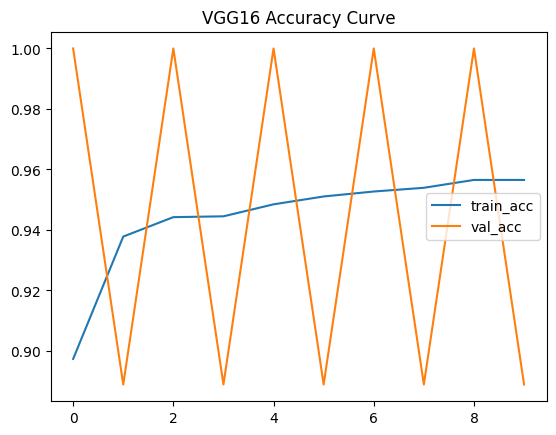

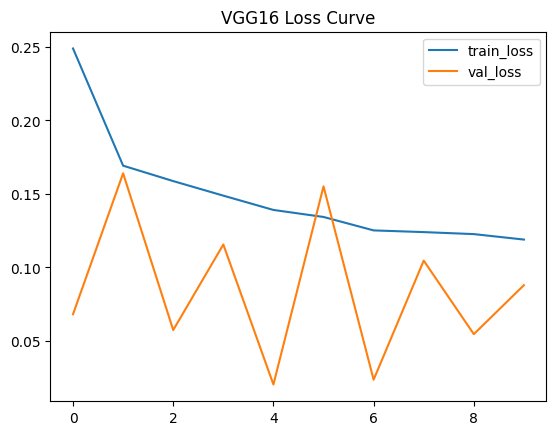

In [ ]:
plt.plot(vgg_history.history['accuracy'], label='train_acc')
plt.plot(vgg_history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title("VGG16 Accuracy Curve")
plt.show()

plt.plot(vgg_history.history['loss'], label='train_loss')
plt.plot(vgg_history.history['val_loss'], label='val_loss')
plt.legend()
plt.title("VGG16 Loss Curve")
plt.show()


In [ ]:
#EfficientNetB0
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

efficient_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze base layers
for layer in efficient_base.layers:
    layer.trainable = False

# Add custom classification head
x = GlobalAveragePooling2D()(efficient_base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)

efficient_model = Model(inputs=efficient_base.input, outputs=output)

efficient_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

efficient_model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
efficient_history = efficient_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


Epoch 1/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 201s 761ms/step - accuracy: 0.4990 - loss: 0.7008 - val_accuracy: 0.5556 - val_loss: 0.6870
Epoch 2/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 146s 636ms/step - accuracy: 0.5010 - loss: 0.6968 - val_accuracy: 0.5556 - val_loss: 0.6891
Epoch 3/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 146s 636ms/step - accuracy: 0.5329 - loss: 0.6916 - val_accuracy: 0.5556 - val_loss: 0.6877
Epoch 4/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 145s 635ms/step - accuracy: 0.5159 - loss: 0.6931 - val_accuracy: 0.5556 - val_loss: 0.6875
Epoch 5/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 146s 635ms/step - accuracy: 0.5279 - loss: 0.6920 - val_accuracy: 0.5556 - val_loss: 0.6873
Epoch 6/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 146s 637ms/step - accuracy: 0.5229 - loss: 0.6927 - val_accuracy: 0.5556 - val_loss: 0.6881
Epoch 7/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 146s 637ms/step - accuracy: 0.5376 - loss: 0.6911 - val_accuracy: 0.5556 - val_loss: 0.6892
Epoch 8/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 146s 637ms/step - accuracy: 0.5339 -

In [ ]:
test_loss, test_acc = efficient_model.evaluate(test_gen)
print("EfficientNetB0 Test Accuracy:", test_acc)


20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 783ms/step - accuracy: 0.2982 - loss: 0.7125
EfficientNetB0 Test Accuracy: 0.6225806474685669


20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 639ms/step


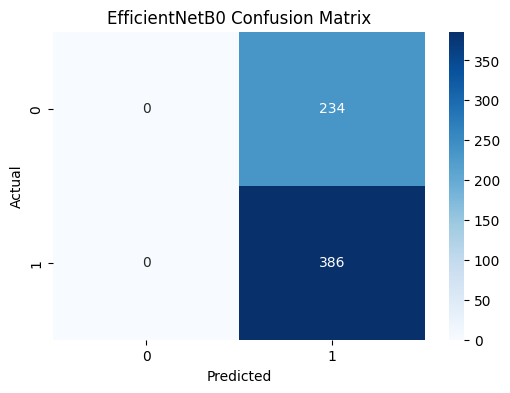

              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00       234
   PNEUMONIA       0.62      1.00      0.77       386

    accuracy                           0.62       620
   macro avg       0.31      0.50      0.38       620
weighted avg       0.39      0.62      0.48       620



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# True labels
true_labels = test_gen.classes

# Predictions
eff_pred_probs = efficient_model.predict(test_gen)
eff_pred_labels = (eff_pred_probs > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(true_labels, eff_pred_labels)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("EfficientNetB0 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print(classification_report(true_labels, eff_pred_labels, target_names=['NORMAL', 'PNEUMONIA']))


In [ ]:
efficient_model.save("pneumonia_efficientnetb0.keras")


In [ ]:
from google.colab import files
files.download("pneumonia_efficientnetb0.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from tensorflow.keras.preprocessing import image
from google.colab import files
import numpy as np

uploaded = files.upload()
img_path = list(uploaded.keys())[0]

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, 0)

eff_pred = efficient_model.predict(img_array)[0][0]

if eff_pred > 0.5:
    print("EfficientNet Prediction: PNEUMONIA")
else:
    print("EfficientNet Prediction: NORMAL")


Saving IM-0006-0001.jpeg to IM-0006-0001.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
EfficientNet Prediction: PNEUMONIA


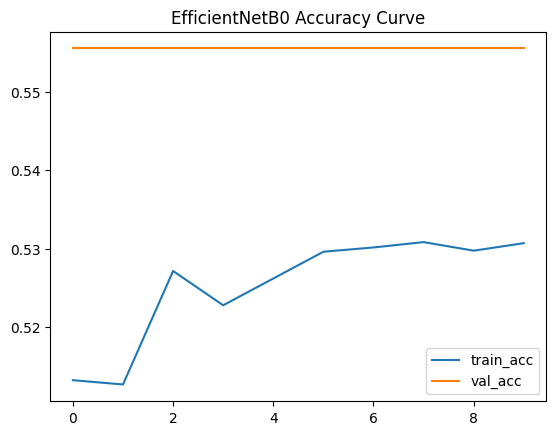

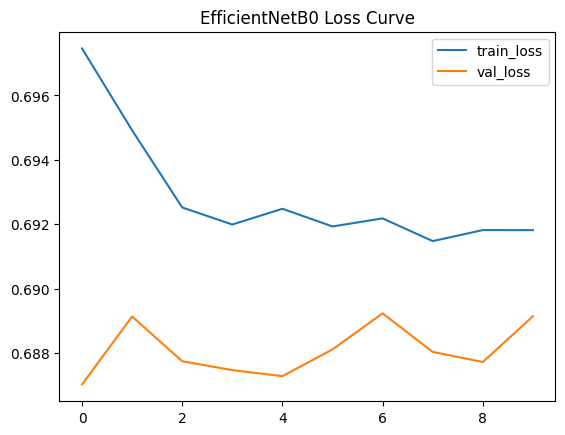

In [ ]:
plt.plot(efficient_history.history['accuracy'], label='train_acc')
plt.plot(efficient_history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title("EfficientNetB0 Accuracy Curve")
plt.show()

plt.plot(efficient_history.history['loss'], label='train_loss')
plt.plot(efficient_history.history['val_loss'], label='val_loss')
plt.legend()
plt.title("EfficientNetB0 Loss Curve")
plt.show()
